<a href="https://colab.research.google.com/github/harshel-karikalan/Complete-Python-3-Bootcamp/blob/master/AlphaConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 170498071/170498071 [00:10<00:00, 15564472.53it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


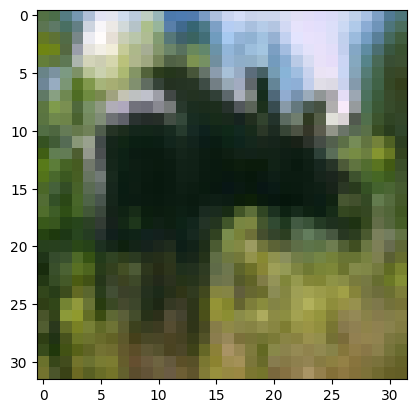

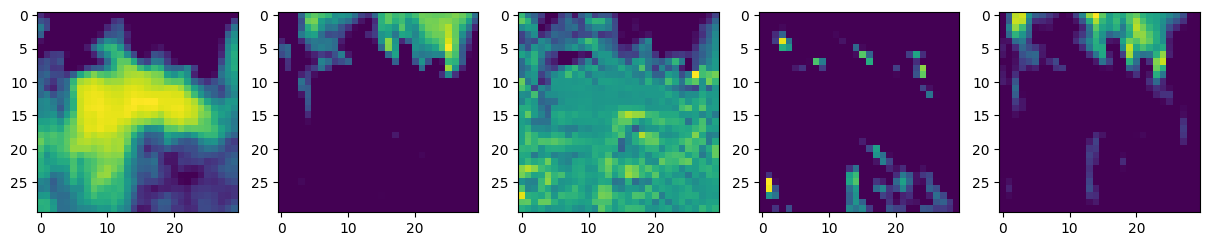

[1] loss: 1.461
[2] loss: 1.122
[3] loss: 0.977
[4] loss: 0.874
[5] loss: 0.800
[6] loss: 0.736
[7] loss: 0.680
[8] loss: 0.630
[9] loss: 0.586
[10] loss: 0.545


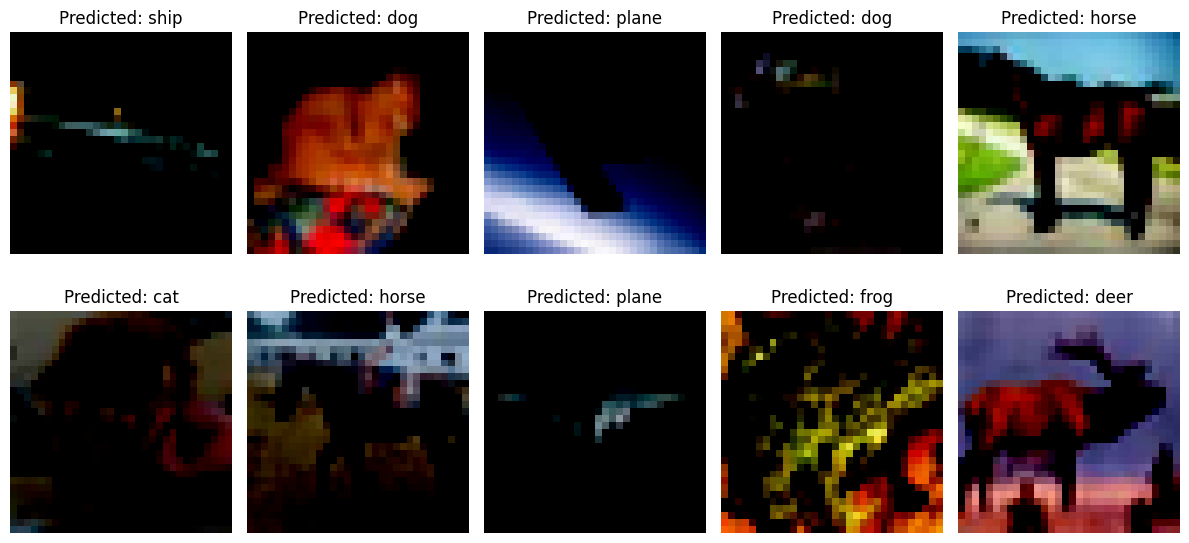

Accuracy of the model: 71.16 %


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)



test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(imgs):
    imgs = imgs / 2 + 0.5   # unnormalize
    npimgs = imgs.detach().numpy()
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))
    plt.show()




class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64*4*4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # N, 3, 32, 32
        x = F.relu(self.conv1(x))   # -> N, 32, 30, 30
        conv1_output=x
        x = self.pool(x)            # -> N, 32, 15, 15
        x = F.relu(self.conv2(x))   # -> N, 64, 13, 13
        x = self.pool(x)            # -> N, 64, 6, 6
        x = F.relu(self.conv3(x))   # -> N, 64, 4, 4
        x = torch.flatten(x, 1)     # -> N, 1024
        x = F.relu(self.fc1(x))     # -> N, 64
        x = self.fc2(x)             # -> N, 10
        return x,conv1_output

model = ConvNet().to(device)
images, labels = next(iter(train_loader))  # Get a batch of images from the data loader

output, conv1_output = model(images)  # Forward pass through the model

# Extract the first 5 channels from conv1_output
first_channels = conv1_output[:, :5, :, :]

# Reshape the first_channels tensor to (N, C, H, W) format
first_channels = first_channels.permute(0, 2, 3, 1).detach().numpy()

# Display the original image
imshow(images[0])

# Display the first 5 channels of the first convolution output for the first image in the batch
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(first_channels[0, :, :, i])
plt.show()

#Training

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):

    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass

        outputs = model(images)[0]
        outputs = outputs.to(device)  # Move the outputs tensor to the device
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

# Select 10 random test images
random_indices = np.random.choice(len(test_dataset), size=10, replace=False)
random_images = [test_dataset[i][0] for i in random_indices]

# Create a subplot grid for displaying the images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i, image in enumerate(random_images):
    # Display the random test image
    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].axis('off')

    # Convert the image to a batch with batch size 1
    image = image.unsqueeze(0)

    # Move the image to the device
    image = image.to(device)

    # Pass the image through the model to get the prediction
    output = model(image)[0]

    # Get the predicted label
    _, predicted_label_idx = torch.max(output, 1)
    predicted_label = classes[predicted_label_idx.item()]

    # Display the predicted label
    axes[i].set_title(f"Predicted: {predicted_label}")

plt.tight_layout()
plt.show()





with torch.no_grad():
    n_correct = 0
    n_samples = len(test_loader.dataset)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)[0]

        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the model: {acc} %')

In [ ]:
# Select 10 random test images
random_indices = np.random.choice(len(test_dataset), size=10, replace=False)
random_images = [test_dataset[i][0] for i in random_indices]

# Create a subplot grid for displaying the images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i, image in enumerate(random_images):
    # Display the random test image
    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].axis('off')

    # Convert the image to a batch with batch size 1
    image = image.unsqueeze(0)

    # Move the image to the device
    image = image.to(device)

    # Pass the image through the model to get the prediction
    output = model(image)[0]

    # Get the predicted label
    _, predicted_label_idx = torch.max(output, 1)
    predicted_label = classes[predicted_label_idx.item()]

    # Display the predicted label
    axes[i].set_title(f"Predicted: {predicted_label}")

plt.tight_layout()
plt.show()

NameError: name 'np' is not defined